In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-cancer-dataset/dataR2.csv


In [2]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd 

In [3]:
import itertools
from itertools import chain
# Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Show metrics 
def show_metrics():
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Accuracy  =     {:.3f}'.format((tp+tn)/(tp+tn+fp+fn)))
    print('Precision =     {:.3f}'.format(tp/(tp+fp)))
    print('Recall    =     {:.3f}'.format(tp/(tp+fn)))
    print('F1_score  =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))


# Precision-recall curve
def plot_precision_recall():
    plt.step(recall, precision, color = 'b', alpha = 0.2,
             where = 'post')
    plt.fill_between(recall, precision, step ='post', alpha = 0.2,
                 color = 'b')

    plt.plot(recall, precision, linewidth=2)
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.show()

# ROC curve
def plot_roc():
    plt.plot(fpr, tpr, label = 'ROC curve', linewidth = 2)
    plt.plot([0,1],[0,1], 'k--', linewidth = 2)
   # plt.xlim([0.0,0.001])
   # plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show();
    
# Learning curve
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None,
                        n_jobs = 1, train_sizes = np.linspace(.1, 1.0, 5)):
    """
    Plots a learning curve. http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r",
             label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g",
             label = "Cross-validation score")
    plt.legend(loc = "best")
    return plt

# Cross val metric
def cross_val_metrics(model) :
    scores = ['accuracy', 'precision', 'recall']
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
        print('[%s] : %0.5f (+/- %0.5f)'%(sc, scores.mean(), scores.std()))

In [4]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [5]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
#     filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [6]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [7]:
df1 = pd.read_csv('/kaggle/input/breast-cancer-dataset/dataR2.csv', delimiter=',')
nRow, nCol = df1.shape
df1.dataframeName = 'train.csv'
print(f'There are {nRow} rows and {nCol} columns')
from sklearn.utils import shuffle
df1 = shuffle(df1)
df1.head(10)

There are 116 rows and 10 columns


,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
46,75,25.700000,94,8.079,1.873251,65.9260,3.741220,4.49685,206.802,1
9,75,23.000000,83,4.952,1.013839,17.1270,11.578990,7.09130,318.302,1
54,49,20.956608,94,12.305,2.853119,11.2406,8.412175,23.11770,573.630,2
26,50,38.578759,106,6.703,1.752611,46.6401,4.667645,11.78388,887.160,1
113,65,32.050000,97,5.730,1.370998,61.4800,22.540000,10.33000,314.050,2
76,55,31.975015,92,16.635,3.775036,37.2234,11.018455,7.16514,483.377,2
23,35,30.276817,84,4.376,0.906707,39.2134,9.048185,16.43706,733.797,1
22,29,32.270788,84,5.810,1.203832,45.6196,6.209635,24.60330,904.981,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1
53,45,20.829995,74,4.560,0.832352,7.7529,8.237405,28.03230,382.955,2


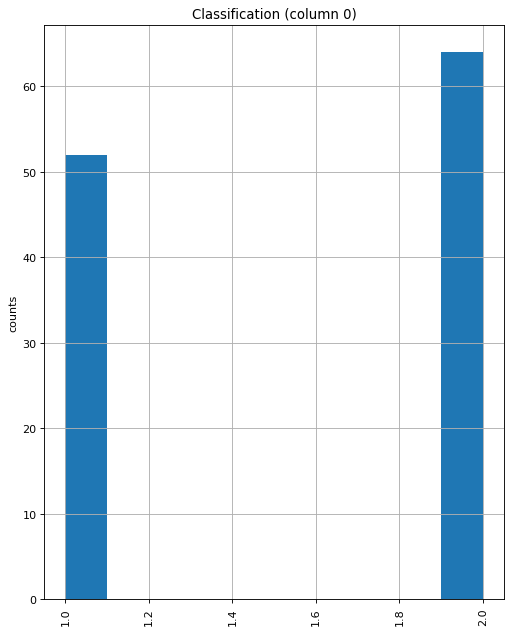

In [8]:
plotPerColumnDistribution(df1, 10, 5)

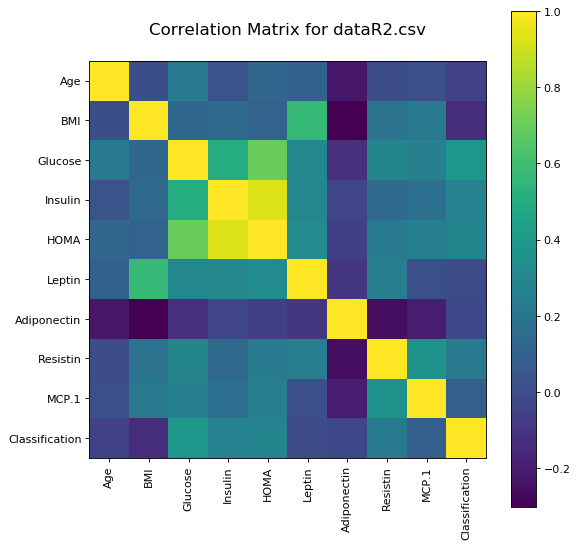

In [9]:
plotCorrelationMatrix(df1, 8)

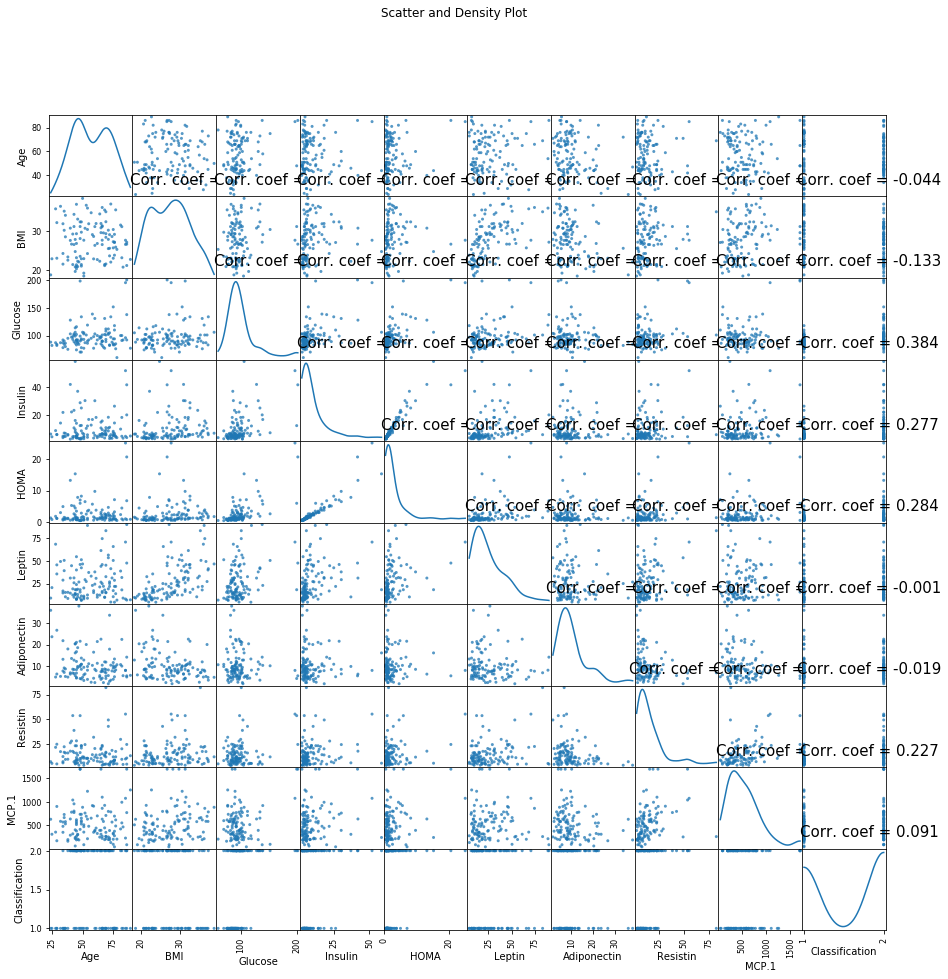

In [10]:
plotScatterMatrix(df1, 15, 15)

In [11]:
data=df1

In [12]:
### Importing Common Modules needed for project
from time import time   # For calculating training time
import pandas as pd    # Pandas is used for handling dataFrames
import pickle      # Pickle is used to load .pkl dataset files
import matplotlib.pyplot as plt    # Pyplot is used for visualizing the information
from sklearn.feature_selection import SelectKBest, f_classif    # For Selecting K-Best features of availabel ones
from sklearn.model_selection import train_test_split, GridSearchCV   # train_test_split for splitting up data
                                                                     # into train and test
                                                                     # GridSearchCV for finding best parameters tuned
from sklearn.model_selection import StratifiedShuffleSplit   # For Cross-Validation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # For evaluating different algorithms
import numpy as np     # Numpy is used to manipulate data operations,
                       # Most of the sklearn libraries expects numpy ndarrays as its default arguments
    
### Importing Models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

In [13]:
# Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Show metrics 
def show_metrics():
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Accuracy  =     {:.3f}'.format((tp+tn)/(tp+tn+fp+fn)))
    print('Precision =     {:.3f}'.format(tp/(tp+fp)))
    print('Recall    =     {:.3f}'.format(tp/(tp+fn)))
    print('F1_score  =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))


In [14]:
df1.describe()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,57.301724,27.582111,97.793103,10.012086,2.694988,26.615080,10.180874,14.725966,534.647000,1.551724
std,16.112766,5.020136,22.525162,10.067768,3.642043,19.183294,6.843341,12.390646,345.912663,0.499475
min,24.000000,18.370000,60.000000,2.432000,0.467409,4.311000,1.656020,3.210000,45.843000,1.000000
25%,45.000000,22.973205,85.750000,4.359250,0.917966,12.313675,5.474282,6.881763,269.978250,1.000000
50%,56.000000,27.662416,92.000000,5.924500,1.380939,20.271000,8.352692,10.827740,471.322500,2.000000
75%,71.000000,31.241442,102.000000,11.189250,2.857787,37.378300,11.815970,17.755207,700.085000,2.000000
max,89.000000,38.578759,201.000000,58.460000,25.050342,90.280000,38.040000,82.100000,1698.440000,2.000000


In [15]:
df1.isnull().values.any()

False

In [16]:
df1['Classification'].replace(1, 0,inplace=True)
df1['Classification'].replace(2, 1,inplace=True)
df1

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
46,75,25.700000,94,8.079,1.873251,65.9260,3.741220,4.49685,206.802,0
9,75,23.000000,83,4.952,1.013839,17.1270,11.578990,7.09130,318.302,0
54,49,20.956608,94,12.305,2.853119,11.2406,8.412175,23.11770,573.630,1
26,50,38.578759,106,6.703,1.752611,46.6401,4.667645,11.78388,887.160,0
113,65,32.050000,97,5.730,1.370998,61.4800,22.540000,10.33000,314.050,1
...,...,...,...,...,...,...,...,...,...,...
114,72,25.590000,82,2.820,0.570392,24.9600,33.750000,3.27000,392.460,1
115,86,27.180000,138,19.910,6.777364,90.2800,14.110000,4.35000,90.090,1
112,62,26.840000,100,4.530,1.117400,12.4500,21.420000,7.32000,330.160,1
72,51,18.370000,105,6.030,1.561770,9.6200,12.760000,3.21000,513.660,1


# Univariate analysis

In [17]:
import warnings
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

warnings.filterwarnings('ignore') #ignore warning messages
# 2 datasets
data=df1
M = data[(data['Classification'] != 1)] #Malignant
B = data[(data['Classification'] == 1)] # healthy
#------------COUNT-----------------------
trace = go.Bar(x = (len(M), len(B)), y = ['malignant', 'benign'], orientation = 'h', opacity = 0.8, marker=dict(
        color=[ 'gold', 'lightskyblue'],
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  'Count of diagnosis variable')
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [18]:

#------------PERCENTAGE-------------------
trace = go.Pie(labels = ['benign','malignant'], values = data['Classification'].value_counts(), 
               textfont=dict(size=15), opacity = 0.8,
               marker=dict(colors=['lightskyblue', 'gold'], 
                           line=dict(color='#000000', width=1.5)))


layout = dict(title =  'Distribution of diagnosis variable')
           
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [19]:
def plot_distribution(data_select, size_bin) :  
    tmp1 = M[data_select]
    tmp2 = B[data_select]
    hist_data = [tmp1, tmp2]
    
    group_labels = ['malignant', 'benign']
    colors = ['#FFD700', '#7EC0EE']

    fig = ff.create_distplot(hist_data, group_labels, colors = colors, show_hist = True, bin_size = size_bin, curve_type='kde')
    
    fig['layout'].update(title = data_select)

    py.iplot(fig, filename = 'Density plot')

In [20]:
plot_distribution('Insulin', .5)
plot_distribution('Age', .5)
plot_distribution('BMI', .5)
plot_distribution('HOMA', .5)
plot_distribution('Leptin', .5)
plot_distribution('Adiponectin', .5)
plot_distribution('Resistin', .5)
plot_distribution('MCP.1', .5)

# correlation analysis

In [21]:
#correlation
correlation = data.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)
#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   xgap = 2,
                   ygap = 2,
                   colorscale='Viridis',
                   colorbar   = dict() ,
                  )
layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                     ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9)),
                       )
                  )
fig = go.Figure(data = [trace],layout = layout)
py.iplot(fig)

In [22]:
df2=df1.drop(['MCP.1'], axis = 1, inplace = False, errors = 'ignore')
df2

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,Classification
46,75,25.700000,94,8.079,1.873251,65.9260,3.741220,4.49685,0
9,75,23.000000,83,4.952,1.013839,17.1270,11.578990,7.09130,0
54,49,20.956608,94,12.305,2.853119,11.2406,8.412175,23.11770,1
26,50,38.578759,106,6.703,1.752611,46.6401,4.667645,11.78388,0
113,65,32.050000,97,5.730,1.370998,61.4800,22.540000,10.33000,1
...,...,...,...,...,...,...,...,...,...
114,72,25.590000,82,2.820,0.570392,24.9600,33.750000,3.27000,1
115,86,27.180000,138,19.910,6.777364,90.2800,14.110000,4.35000,1
112,62,26.840000,100,4.530,1.117400,12.4500,21.420000,7.32000,1
72,51,18.370000,105,6.030,1.561770,9.6200,12.760000,3.21000,1


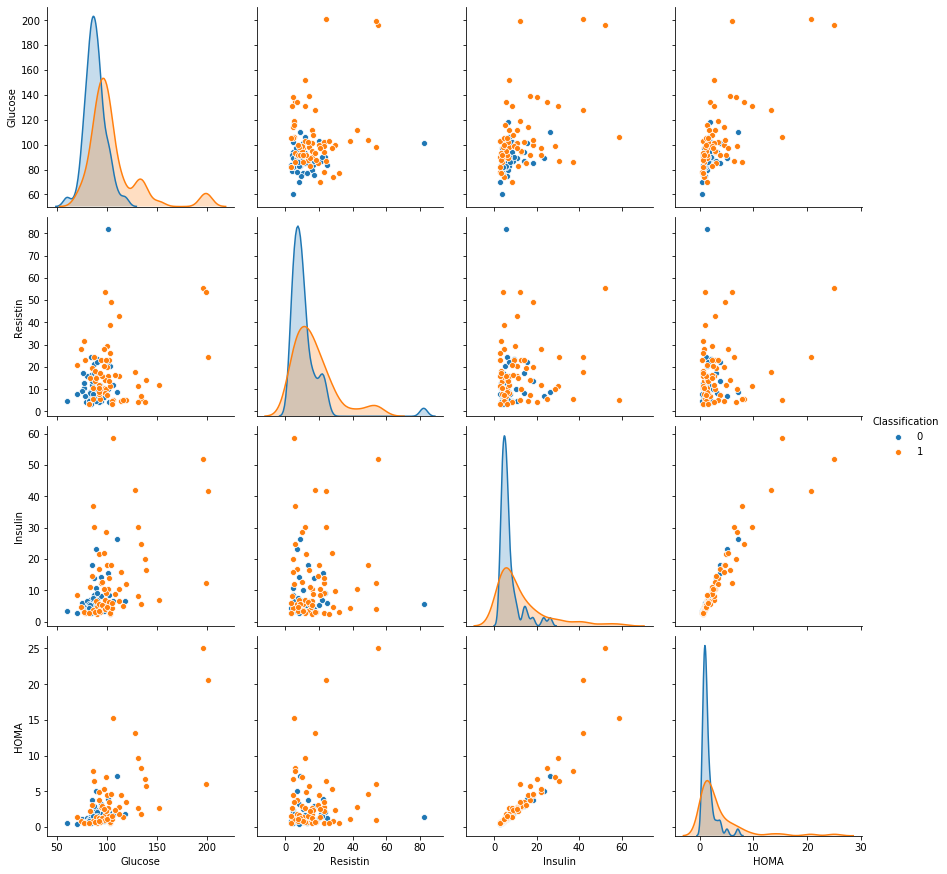

In [23]:
features_2=['Glucose','Resistin','Insulin','HOMA','Classification']
import seaborn as sns
sns.pairplot(df1[features_2],hue='Classification',size=3)
plt.savefig('pairplot.png')

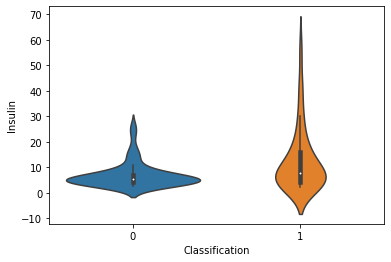

In [24]:
sns.violinplot(x='Classification',y='Insulin',data=df1,size=8)
plt.savefig('violin_insulin.png')

* Categorical scatterplots:
* 
* stripplot() (with kind="strip"; the default)
* 
* swarmplot() (with kind="swarm")
* 
* Categorical distribution plots:
* 
* boxplot() (with kind="box")
* 
* violinplot() (with kind="violin")
* 
* boxenplot() (with kind="boxen")
* 
* Categorical estimate plots:
* 
* pointplot() (with kind="point")
* 
* barplot() (with kind="bar")
* 
* * countplot() (with kind="count")

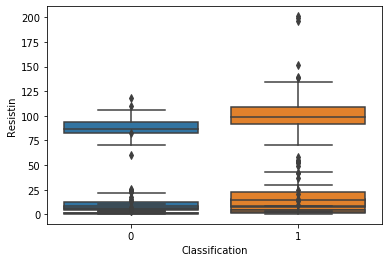

In [25]:
sns.boxplot(x="Classification", y="Glucose", data=df1)
plt.savefig('box_glucose.png')
sns.boxplot(x="Classification", y="Insulin", data=df1)
plt.savefig('box_insulin.png')
sns.boxplot(x="Classification", y="HOMA", data=df1)
plt.savefig('box_homa.png')
sns.boxplot(x="Classification", y="Resistin", data=df1)
plt.savefig('box_resistin.png')

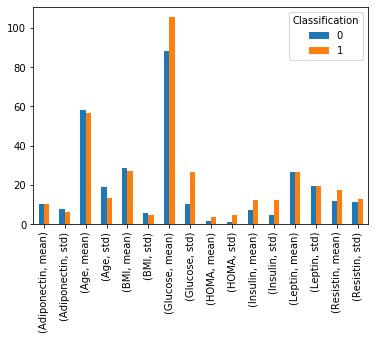

In [26]:
temp=df2.groupby('Classification').describe().swaplevel(0, 1, 1).sort_index(1)[['mean','std']].swaplevel(0, 1, 1).sort_index(1).T
temp.plot.bar()

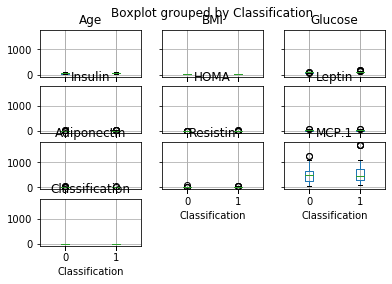

In [27]:
import seaborn as sns
boxplot = df1.boxplot(column=[x for x in df1.columns[:]],by='Classification')

Positive corelated features

In [28]:
def plot_feat1_feat2(feat1, feat2) :  
    trace0 = go.Scatter(
        x = M[feat1],
        y = M[feat2],
        name = 'malignant',
        mode = 'markers', 
        marker = dict(color = '#FFD700',
            line = dict(
                width = 1)))

    trace1 = go.Scatter(
        x = B[feat1],
        y = B[feat2],
        name = 'benign',
        mode = 'markers',
        marker = dict(color = '#7EC0EE',
            line = dict(
                width = 1)))

    layout = dict(title = feat1 +" "+"vs"+" "+ feat2,
                  yaxis = dict(title = feat2,zeroline = False),
                  xaxis = dict(title = feat1, zeroline = False)
                 )

    plots = [trace0, trace1]

    fig = dict(data = plots, layout=layout)
    py.iplot(fig)

In [29]:
plot_feat1_feat2('HOMA','Insulin')
plot_feat1_feat2('Glucose','HOMA')
plot_feat1_feat2('Glucose','Insulin')

In [30]:
data.columns

Index(['Age', 'BMI', 'Glucose', 'Insulin', 'HOMA', 'Leptin', 'Adiponectin',
       'Resistin', 'MCP.1', 'Classification'],
      dtype='object')

In [31]:
y = df1.iloc[:,-1].values
X = df1.iloc[:,0:-1].values

selector = SelectKBest( k='all').fit(X,y)
x_new = selector.transform(X) # not needed to get the score
scores = selector.scores_
for col in df1.columns:
    print(col,end=' ')
scores

Age BMI Glucose Insulin HOMA Leptin Adiponectin Resistin MCP.1 Classification 

array([2.16670196e-01, 2.03986225e+00, 1.97554544e+01, 9.45950374e+00,
       1.00023983e+01, 1.32589978e-04, 4.33217509e-02, 6.21131511e+00,
       9.59961532e-01])

In [32]:
features=[]
for col in df1.columns:
    features.append(col)
features=features[:-1]

In [33]:
features_2=['Age',
 'BMI',
 'Glucose',
 'Resistin']

In [34]:
### Importing Common Modules needed for project
from time import time   # For calculating training time
import pandas as pd    # Pandas is used for handling dataFrames
import pickle      # Pickle is used to load .pkl dataset files
import matplotlib.pyplot as plt    # Pyplot is used for visualizing the information
from sklearn.feature_selection import SelectKBest, f_classif    # For Selecting K-Best features of availabel ones
from sklearn.model_selection import train_test_split, GridSearchCV   # train_test_split for splitting up data
                                                                     # into train and test
                                                                     # GridSearchCV for finding best parameters tuned
from sklearn.model_selection import StratifiedShuffleSplit   # For Cross-Validation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # For evaluating different algorithms
import numpy as np     # Numpy is used to manipulate data operations,
                       # Most of the sklearn libraries expects numpy ndarrays as its default arguments

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
### Importing Models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import preprocessing

# x = df1[features].values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df1[features] = pd.DataFrame(x_scaled)
df1.head()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
46,75,25.700000,94,8.079,1.873251,65.9260,3.741220,4.49685,206.802,0
9,75,23.000000,83,4.952,1.013839,17.1270,11.578990,7.09130,318.302,0
54,49,20.956608,94,12.305,2.853119,11.2406,8.412175,23.11770,573.630,1
26,50,38.578759,106,6.703,1.752611,46.6401,4.667645,11.78388,887.160,0
113,65,32.050000,97,5.730,1.370998,61.4800,22.540000,10.33000,314.050,1


In [35]:
X=df1[features] #features or features_2
y=df1['Classification']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=42)

In [36]:
y_test.value_counts() # 1-positive 0- healthy

1    22
0    17
Name: Classification, dtype: int64

In [37]:
pd.set_option('display.max_rows', 200)

In [38]:
X_train.head()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1
33,43,34.422174,89,23.194,5.091856,31.2128,8.300955,6.71026,960.246
109,75,30.480000,152,7.010,2.628283,50.5300,10.060000,11.73000,99.450
114,72,25.590000,82,2.820,0.570392,24.9600,33.750000,3.27000,392.460
76,55,31.975015,92,16.635,3.775036,37.2234,11.018455,7.16514,483.377
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220


In [39]:
from sklearn.linear_model import SGDClassifier
import time
start = time.time()

clf = SGDClassifier()
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
scores = cross_val_score(clf, X, y, cv=5)

end = time.time()

# accuracy_all.append(accuracy_score(prediction, y_test))
# cvs_all.append(np.mean(scores))

print("SGD Classifier Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))
print("Execution time: {0:.5} seconds \n".format(end-start))
print(classification_report( y_test,prediction))


SGD Classifier Accuracy: 58.97%
Cross validation score: 56.12% (+/- 20.58%)
Execution time: 0.030351 seconds 

              precision    recall  f1-score   support

           0       0.57      0.24      0.33        17
           1       0.59      0.86      0.70        22

    accuracy                           0.59        39
   macro avg       0.58      0.55      0.52        39
weighted avg       0.58      0.59      0.54        39



In [40]:
from sklearn.svm import SVC, NuSVC, LinearSVC

start = time.time()

clf = SVC(kernel='linear',C=1,gamma=1)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
scores = cross_val_score(clf, X, y, cv=5)


end = time.time()
labels = np.unique(y_test)
# accuracy_all.append(accuracy_score(prediction, y_test))
# cvs_all.append(np.mean(scores))

print("SVC LINEAR Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))
print("Execution time: {0:.5} seconds \n".format(end-start))
print(classification_report(y_test, prediction))

print(confusion_matrix(y_test, prediction,labels=labels))

start = time.time()

clf_svmpoly = SVC(kernel='poly')
clf_svmpoly.fit(X_train, y_train)
prediction = clf_svmpoly.predict(X_test)
scores = cross_val_score(clf_svmpoly, X, y, cv=5)


end = time.time()

# accuracy_all.append(accuracy_score(prediction, y_test))
# cvs_all.append(np.mean(scores))

print("SVC POLY Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))
print("Execution time: {0:.5} seconds \n".format(end-start))
print(classification_report(y_test, prediction))

start = time.time()

clf_svmsigmoid = SVC(kernel='sigmoid',probability=True)
clf_svmsigmoid.fit(X_train, y_train)
prediction = clf_svmsigmoid.predict(X_test)
scores = cross_val_score(clf_svmsigmoid, X, y, cv=5)

end = time.time()

# accuracy_all.append(accuracy_score(prediction, y_test))
# cvs_all.append(np.mean(scores))

print("SVC SIGMOID Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))
print("Execution time: {0:.5} seconds \n".format(end-start))
print(classification_report(y_test, prediction))


start = time.time()

clf_svmrbf = SVC(kernel='rbf',probability=True)
clf_svmrbf.fit(X_train, y_train)
prediction = clf_svmrbf.predict(X_test)
scores = cross_val_score(clf_svmrbf, X, y, cv=5)


end = time.time()

# accuracy_all.append(accuracy_score(prediction, y_test))
# cvs_all.append(np.mean(scores))

print("SVC RBF Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))
print("Execution time: {0:.5} seconds \n".format(end-start))
print(classification_report( y_test,prediction))
start = time.time()

clf_svmnu = NuSVC()
clf_svmnu.fit(X_train, y_train)
prediciton = clf_svmnu.predict(X_test)
scores = cross_val_score(clf_svmnu, X, y, cv=5)
end = time.time()


print("NuSVC Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))
print("Execution time: {0:.5} seconds \n".format(end-start))
print(classification_report( y_test,prediction))
start = time.time()

clf_svmlinear = LinearSVC()
clf_svmlinear.fit(X_train, y_train)
prediction = clf_svmlinear.predict(X_test)
scores = cross_val_score(clf_svmlinear, X, y, cv=5)


print("LinearSVC Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))
print("Execution time: {0:.5} seconds \n".format(end-start))
print(classification_report( y_test,prediction))

SVC LINEAR Accuracy: 66.67%
Cross validation score: 74.96% (+/- 15.15%)
Execution time: 12.507 seconds 

              precision    recall  f1-score   support

           0       0.61      0.65      0.63        17
           1       0.71      0.68      0.70        22

    accuracy                           0.67        39
   macro avg       0.66      0.66      0.66        39
weighted avg       0.67      0.67      0.67        39

[[11  6]
 [ 7 15]]
SVC POLY Accuracy: 56.41%
Cross validation score: 54.31% (+/- 3.89%)
Execution time: 0.030299 seconds 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.56      1.00      0.72        22

    accuracy                           0.56        39
   macro avg       0.28      0.50      0.36        39
weighted avg       0.32      0.56      0.41        39

SVC SIGMOID Accuracy: 53.85%
Cross validation score: 50.87% (+/- 3.48%)
Execution time: 0.039119 seconds 

           

LINAER SVC with Gridsearch CV

C=1 and gamma=1 and kernel=linear are optimal parameteres

In [41]:
# from sklearn.model_selection import GridSearchCV 

# # 'C': [0.001,0.1, 1, 10, 100, 1000],  
# # #               'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
# # defining parameter range 
# param_grid = {'C': [0.001,0.1, 1, 10, 100, 1000],  
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
#               'kernel': ['linear']}  
  
# grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# # fitting the model for grid search 
# grid.fit(X_train, y_train) 

# # print best parameter after tuning 
# print(grid.best_params_) 

# # print how our model looks after hyper-parameter tuning 



# print(grid.best_estimator_) 

# grid_predictions = grid.predict(X_test) 

# # print classification report 
# print(classification_report(y_test, grid_predictions)) 

In [42]:
# from sklearn.externals import joblib
# joblib.dump(grid, 'grid_object.pkl')

SVC LINEAR: ROC AUC=0.734


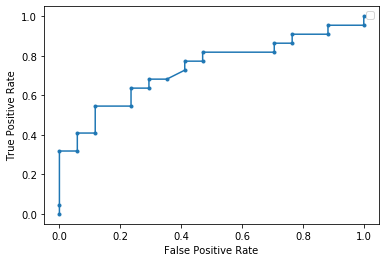

SVC LINEAR Accuracy: 66.67%
Cross validation score: 74.96% (+/- 15.15%)
Execution time: 56.866 seconds 

Accuracy: 0.666667
Precision: 0.681818
Recall: 0.714286
F1 score: 0.697674
ROC AUC: 0.733957
              precision    recall  f1-score   support

           0       0.61      0.65      0.63        17
           1       0.71      0.68      0.70        22

    accuracy                           0.67        39
   macro avg       0.66      0.66      0.66        39
weighted avg       0.67      0.67      0.67        39

[[11  6]
 [ 7 15]]


In [43]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot

start = time.time()

clf_svc = SVC(kernel='linear',C=1,gamma=1,probability=True)
clf_svc.fit(X_train, y_train)
prediction = clf_svc.predict(X_test)
scores = cross_val_score(clf_svc, X, y, cv=5)

lr_probs = clf_svc.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
print('SVC LINEAR: ROC AUC=%.3f' % (lr_auc))
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

pyplot.plot(lr_fpr, lr_tpr, marker='.')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


end = time.time()
# accuracy_all.append(accuracy_score(prediction, y_test))
# cvs_all.append(np.mean(scores))

print("SVC LINEAR Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))
print("Execution time: {0:.5} seconds \n".format(end-start))
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(prediction, y_test)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(prediction, y_test)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(prediction, y_test)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(prediction, y_test)
print('F1 score: %f' % f1)
 
# # kappa
# kappa = cohen_kappa_score(prediction, y_test)
# print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, lr_probs)
print('ROC AUC: %f' % auc)
print(classification_report(y_test, prediction))
print(confusion_matrix(y_test, prediction,labels=labels))

In [44]:
clf_dt = DecisionTreeClassifier()

# Train model and make predictions
y_hat = clf_dt.fit(X_train, y_train).predict(X_test)

print(classification_report(y_test, y_hat))

print(confusion_matrix(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.59      0.59      0.59        17
           1       0.68      0.68      0.68        22

    accuracy                           0.64        39
   macro avg       0.64      0.64      0.64        39
weighted avg       0.64      0.64      0.64        39

[[10  7]
 [ 7 15]]


In [45]:
from sklearn.neighbors import KNeighborsClassifier

start = time.time()

clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)
prediction = clf_knn.predict(X_test)
scores = cross_val_score(clf_knn, X, y, cv=5)


end = time.time()


print("KNN Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))
print("Execution time: {0:.5} seconds \n".format(end-start))
print(classification_report( y_test,prediction))

KNN Accuracy: 43.59%
Cross validation score: 62.90% (+/- 22.57%)
Execution time: 0.040994 seconds 

              precision    recall  f1-score   support

           0       0.31      0.24      0.27        17
           1       0.50      0.59      0.54        22

    accuracy                           0.44        39
   macro avg       0.40      0.41      0.40        39
weighted avg       0.42      0.44      0.42        39



In [46]:
from sklearn.naive_bayes import GaussianNB

start = time.time()

clf_gnb = GaussianNB()
clf_gnb.fit(X_train, y_train)
prediction = clf_gnb.predict(X_test)
scores = cross_val_score(clf_gnb, X, y, cv=5)
end = time.time()

print("Gaussian NB Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))
print("Execution time: {0:.5} seconds \n".format(end-start))
print(classification_report( y_test,prediction))

Gaussian NB Accuracy: 69.23%
Cross validation score: 60.33% (+/- 8.75%)
Execution time: 0.026359 seconds 

              precision    recall  f1-score   support

           0       0.60      0.88      0.71        17
           1       0.86      0.55      0.67        22

    accuracy                           0.69        39
   macro avg       0.73      0.71      0.69        39
weighted avg       0.75      0.69      0.69        39



Univariate features results

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

cols=df1.columns[:-1]
for feature in cols:
    print(feature,'****************')
    X=df1[feature]
    y=df1['Classification']
    X=X.values.reshape(-1,1)
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y,test_size=0.33,random_state=42)
        

    clf_rf = RandomForestClassifier()
    clf_rf.fit(X_train1, y_train1)
    y_pred = clf_rf.predict(X_test1)
    y_score = clf_rf.predict_proba(X_test1)[:,1]
    # Confusion maxtrix & metrics
    cm = confusion_matrix(y_test1, y_pred)
    print(cm)
    print("Random Forest Accuracy: {0:.2%}".format(accuracy_score(y_pred, y_test1)))
    print(classification_report( y_test1,y_pred))
    fpr, tpr, t = roc_curve(y_test1, y_score)
    #plot_roc()
    from sklearn.metrics import roc_auc_score
    print('auc= ',roc_auc_score(y_test1,y_score))

Age ****************
[[ 9  8]
 [ 7 15]]
Random Forest Accuracy: 61.54%
              precision    recall  f1-score   support

           0       0.56      0.53      0.55        17
           1       0.65      0.68      0.67        22

    accuracy                           0.62        39
   macro avg       0.61      0.61      0.61        39
weighted avg       0.61      0.62      0.61        39

auc=  0.6310160427807486
BMI ****************
[[ 7 10]
 [ 7 15]]
Random Forest Accuracy: 56.41%
              precision    recall  f1-score   support

           0       0.50      0.41      0.45        17
           1       0.60      0.68      0.64        22

    accuracy                           0.56        39
   macro avg       0.55      0.55      0.54        39
weighted avg       0.56      0.56      0.56        39

auc=  0.5347593582887701
Glucose ****************
[[ 3 14]
 [ 6 16]]
Random Forest Accuracy: 48.72%
              precision    recall  f1-score   support

           0       0.33 

In [48]:
# parameters = {'min_samples_split':np.arange(2, 80), 'max_depth': np.arange(2,10), 'criterion':['gini', 'entropy']}
# rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 
# grid = GridSearchCV(rfc, parameters,scoring='accuracy', cv=10)
# grid.fit(X_train,y_train)
# print('The parameters combination that would give best accuracy is : ')
# print(grid.best_params_)
# print('The best accuracy achieved after parameter tuning via grid search is : ', grid.best_score_)
# import pickle
# best_param_rf=grid.best_params_
# # Store data (serialize)
# with open('best_param_rf.pickle', 'wb') as handle:
#     pickle.dump(best_param_rf, handle, protocol=pickle.HIGHEST_PROTOCOL)
# best_param_rf

KFOLD cross validation

In [49]:
from sklearn import model_selection
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
scoring = 'roc_auc'
results = model_selection.cross_val_score(clf_rf, X, y, cv=kfold, scoring=scoring)
# print(results,results.mean(),results.std())
print("Accuracy: %.3f (%.3f)" % (results.mean(), results.std()))

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

# predicting with 95% Confidence interval

Univariate single feature at a time

In [50]:
cols=df1.columns[:-1]
# values = df1.values
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
# configure bootstrap
for col in cols:
    print(col)
    values=df1[[col,'Classification']].values
    n_iterations = 100
    n_size = int(len(data) * 0.80)
    # run bootstrap
    stats = list()
    score_speci=[]
    score_precision=[]
    score_recall=[]
    score_f1=[]
    score_auc=[]
    for i in range(n_iterations):
        # prepare train and test sets
        train = resample(values, n_samples=n_size)
        test = np.array([x for x in values if x.tolist() not in train.tolist()])
        # fit model
        model = RandomForestClassifier()
        model.fit(train[:,:-1], train[:,-1])
        # evaluate model
        predictions = model.predict(test[:,:-1])
        score = accuracy_score(test[:,-1], predictions)
        cm=confusion_matrix(test[:,-1], predictions)
        tp = cm[1,1]
        fn = cm[1,0]
        fp = cm[0,1]
        tn = cm[0,0]
        y_score = model.predict_proba(test[:,:-1])[:,1]
        score_auc.append(roc_auc_score(test[:,-1],y_score))
        score_speci.append((tn)/(tn+fp))
        score_precision.append(tp/(tp+fp))
        score_recall.append(tp/(tp+fn))
        score_f1.append(2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))
        # print(score)
        stats.append(score)
    # confidence intervals
    alpha = 0.95
    p_lower = ((1.0-alpha)/2.0) * 100
    p_upper = (alpha+((1.0-alpha)/2.0)) * 100

    print('Accuracy %.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, max(0.0, np.percentile(stats, p_lower))*100, min(1.0, np.percentile(stats, p_upper))*100))
#     print(np.asarray(stats).mean(),np.asarray(stats).std())
    print('Precision %.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, max(0.0, np.percentile(score_precision, p_lower))*100, min(1.0, np.percentile(score_precision, p_upper))*100))
#     print(np.asarray(score_precision).mean(),np.asarray(score_precision).std())
    print('Recall %.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, max(0.0, np.percentile(score_recall, p_lower))*100, min(1.0, np.percentile(score_recall, p_upper))*100))
#     print(np.asarray(score_recall).mean(),np.asarray(score_recall).std())
    print('F1 score %.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, max(0.0, np.percentile(score_f1, p_lower))*100, min(1.0, np.percentile(score_f1, p_upper))*100))
#     print(np.asarray(score_f1).mean(),np.asarray(score_f1).std())
    print('Specificity %.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, max(0.0, np.percentile(score_speci, p_lower))*100, min(1.0, np.percentile(score_speci, p_upper))*100))
#     print(np.asarray(score_speci).mean(),np.asarray(score_speci).std())
    print('AUC %.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, max(0.0, np.percentile(score_auc, p_lower))*100, min(1.0, np.percentile(score_auc, p_upper))*100))
#     print(np.asarray(score_auc).mean(),np.asarray(score_auc).std())

Age
Accuracy 95.0 confidence interval 25.5% and 60.0%
Precision 95.0 confidence interval 17.7% and 60.8%
Recall 95.0 confidence interval 15.6% and 86.8%
F1 score 95.0 confidence interval 0.0% and 100.0%
Specificity 95.0 confidence interval 14.9% and 63.4%
AUC 95.0 confidence interval 24.5% and 67.4%
BMI
Accuracy 95.0 confidence interval 32.6% and 56.3%
Precision 95.0 confidence interval 33.9% and 62.5%
Recall 95.0 confidence interval 26.5% and 78.0%
F1 score 95.0 confidence interval 32.0% and 63.4%
Specificity 95.0 confidence interval 19.6% and 61.3%
AUC 95.0 confidence interval 27.6% and 60.4%
Glucose
Accuracy 95.0 confidence interval 20.7% and 61.4%
Precision 95.0 confidence interval 21.8% and 72.4%
Recall 95.0 confidence interval 20.4% and 74.2%
F1 score 95.0 confidence interval 21.3% and 70.2%
Specificity 95.0 confidence interval 0.0% and 55.6%
AUC 95.0 confidence interval 21.5% and 66.2%
Insulin
Accuracy 95.0 confidence interval 36.8% and 56.3%
Precision 95.0 confidence interval 3

bivariate 95% CI

In [51]:
cols=df1.columns[:-1]
# values = df1.values
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
models=[RandomForestClassifier(),SVC(kernel='linear',C=1,gamma=1,probability=True),LogisticRegression()]
# configure bootstrap
for col in cols[1:]:
    print(cols[0],col)
    values=df1[[cols[0],col,'Classification']].values
    for m in models:
        print(m)
        n_iterations = 100
        n_size = int(len(data) * 0.80)
        # run bootstrap
        stats = list()
        score_speci=[]
        score_precision=[]
        score_recall=[]
        score_f1=[]
        score_auc=[]
        for i in range(n_iterations):
            # prepare train and test sets
            train = resample(values, n_samples=n_size)
            test = np.array([x for x in values if x.tolist() not in train.tolist()])
            # fit model
            model = m
            model.fit(train[:,:-1], train[:,-1])
            # evaluate model
            predictions = model.predict(test[:,:-1])
            score = accuracy_score(test[:,-1], predictions)
            cm=confusion_matrix(test[:,-1], predictions)
            tp = cm[1,1]
            fn = cm[1,0]
            fp = cm[0,1]
            tn = cm[0,0]
            y_score = model.predict_proba(test[:,:-1])[:,1]
            score_auc.append(roc_auc_score(test[:,-1],y_score))
            score_speci.append((tn)/(tn+fp))
            score_precision.append(tp/(tp+fp))
            score_recall.append(tp/(tp+fn))
            score_f1.append(2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))
            # print(score)
            stats.append(score)
        # confidence intervals
        alpha = 0.95
        p_lower = ((1.0-alpha)/2.0) * 100
        p_upper = (alpha+((1.0-alpha)/2.0)) * 100

        print('Accuracy %.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, max(0.0, np.percentile(stats, p_lower))*100, min(1.0, np.percentile(stats, p_upper))*100))
    #     print(np.asarray(stats).mean(),np.asarray(stats).std())
        print('Precision %.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, max(0.0, np.percentile(score_precision, p_lower))*100, min(1.0, np.percentile(score_precision, p_upper))*100))
    #     print(np.asarray(score_precision).mean(),np.asarray(score_precision).std())
        print('Recall %.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, max(0.0, np.percentile(score_recall, p_lower))*100, min(1.0, np.percentile(score_recall, p_upper))*100))
    #     print(np.asarray(score_recall).mean(),np.asarray(score_recall).std())
        print('F1 score %.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, max(0.0, np.percentile(score_f1, p_lower))*100, min(1.0, np.percentile(score_f1, p_upper))*100))
    #     print(np.asarray(score_f1).mean(),np.asarray(score_f1).std())
        print('Specificity %.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, max(0.0, np.percentile(score_speci, p_lower))*100, min(1.0, np.percentile(score_speci, p_upper))*100))
    #     print(np.asarray(score_speci).mean(),np.asarray(score_speci).std())
        print('AUC %.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, max(0.0, np.percentile(score_auc, p_lower))*100, min(1.0, np.percentile(score_auc, p_upper))*100))
    #     print(np.asarray(score_auc).mean(),np.asarray(score_auc).std())

Age BMI
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy 95.0 confidence interval 48.9% and 76.8%
Precision 95.0 confidence interval 49.8% and 80.0%
Recall 95.0 confidence interval 48.0% and 86.5%
F1 score 95.0 confidence interval 54.7% and 80.7%
Specificity 95.0 confidence interval 38.1% and 77.8%
AUC 95.0 confidence interval 55.7% and 77.7%
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    

best and worst ROC curve with k fold cross validation 

In [52]:
cv = StratifiedKFold(n_splits=10)
classifier = SVC(kernel='linear',C=1,gamma=1,probability=True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(X_train, y_train):
    probas_ = classifier.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

NameError: name 'StratifiedKFold' is not defined

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

start = time.time()

clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
prediction = clf_rf.predict(X_test)
y_score = clf_rf.predict_proba(X_test)[:,1]
scores = cross_val_score(clf_rf, X, y, cv=5)
end = time.time()

print("Random Forest Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))
print("Execution time: {0:.5} seconds \n".format(end-start))
print(classification_report( y_test,prediction))
from sklearn.metrics import roc_auc_score
print('auc= ',roc_auc_score(y_test,y_score))

start = time.time()

clf_et = ExtraTreesClassifier()
clf_et.fit(X_train, y_train)
prediction = clf_et.predict(X_test)
scores = cross_val_score(clf_et, X, y, cv=5)

end = time.time()


print("Extra Trees Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))
print("Execution time: {0:.5} seconds \n".format(end-start))
print(classification_report( y_test,prediction))
start = time.time()

clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)
prediction = clf_dt.predict(X_test)
scores = cross_val_score(clf_dt, X, y, cv=5)
print(confusion_matrix( y_test,prediction))
end = time.time()

print("Dedicion Tree Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))
print("Execution time: {0:.5} seconds \n".format(end-start))
print(classification_report( y_test,prediction))


Random Forest Accuracy: 69.23%
Cross validation score: 54.35% (+/- 18.24%)
Execution time: 1.328 seconds 

              precision    recall  f1-score   support

           0       0.78      0.41      0.54        17
           1       0.67      0.91      0.77        22

    accuracy                           0.69        39
   macro avg       0.72      0.66      0.65        39
weighted avg       0.72      0.69      0.67        39

auc=  0.7767379679144385
Extra Trees Accuracy: 76.92%
Cross validation score: 54.35% (+/- 18.24%)
Execution time: 0.96078 seconds 

              precision    recall  f1-score   support

           0       0.79      0.65      0.71        17
           1       0.76      0.86      0.81        22

    accuracy                           0.77        39
   macro avg       0.77      0.76      0.76        39
weighted avg       0.77      0.77      0.77        39

[[10  7]
 [ 3 19]]
Dedicion Tree Accuracy: 74.36%
Cross validation score: 54.35% (+/- 18.24%)
Execution tim

In [54]:
from multiscorer_py import MultiScorer
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score          
from sklearn.model_selection import cross_val_score
from numpy import average

scorer = MultiScorer({
    'Accuracy'  : (accuracy_score , {}),
    'Precision' : (precision_score, {'pos_label': 3, 'average':'macro'}),
    'Recall'    : (recall_score   , {'pos_label': 3, 'average':'macro'}),
    'AUC'       : (roc_auc_score,{}),
    'F1 score'  : (f1_score,{})
}) 

models = [clf_svc, clf_dt, clf_knn,clf_gnb,clf_rf,clf_et,clf_svmrbf,clf_svmsigmoid,clf_svmpoly,clf_svmnu,clf_svmlinear]
names = ['SVC', 'Decision Tree', 'KNN','Gaussian Naive bayes','Random forest','Extra trees','SVM RBF','SVM Sigmoid','SVM poly','SVM Nu','SVM linear']
print('10 Fold cross Validation results')
for model, name in zip(models, names):
    print(name)

    _ = cross_val_score(model, X, y,scoring=scorer, cv=10) # Added assignment of the result to `_` in order to illustrate that the return value will not be used
    results = scorer.get_results()

    for metric_name in results.keys():
        average_score = np.average(results[metric_name])
        print('%s : %f' % (metric_name, average_score))

10 Fold cross Validation results
SVC
Accuracy : 0.551515
Precision : 0.275758
Recall : 0.500000
AUC : 0.500000
F1 score : 0.710423
Decision Tree
Accuracy : 0.537500
Precision : 0.394645
Recall : 0.508690
AUC : 0.508690
F1 score : 0.633920
KNN
Accuracy : 0.510354
Precision : 0.414585
Recall : 0.486667
AUC : 0.486667
F1 score : 0.598530
Gaussian Naive bayes
Accuracy : 0.503220
Precision : 0.424101
Recall : 0.484881
AUC : 0.484881
F1 score : 0.572125
Random forest
Accuracy : 0.507273
Precision : 0.441987
Recall : 0.491381
AUC : 0.491381
F1 score : 0.569184
Extra trees
Accuracy : 0.508586
Precision : 0.452681
Recall : 0.494524
AUC : 0.494524
F1 score : 0.565574
SVM RBF
Accuracy : 0.512229
Precision : 0.426757
Recall : 0.492925
AUC : 0.492925
F1 score : 0.583991
SVM Sigmoid
Accuracy : 0.509470
Precision : 0.434290
Recall : 0.492202
AUC : 0.492202
F1 score : 0.576975
SVM poly
Accuracy : 0.514141
Precision : 0.416675
Recall : 0.493069
AUC : 0.493069
F1 score : 0.591803
SVM Nu
Accuracy : 0.513

In [55]:
# n_estimators = [100, 300, 500, 800, 1200]
# max_depth = [5, 8, 15, 25, 30]
# min_samples_split = [2, 5, 10, 15, 100]
# min_samples_leaf = [1, 2, 5, 10] 
# forest = RandomForestClassifier(random_state = 1, n_estimators = 10, min_samples_split = 1)
# hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
#               min_samples_split = min_samples_split, 
#              min_samples_leaf = min_samples_leaf)

# gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
#                       n_jobs = -1)
# bestF = gridF.fit(X_train, y_train)

In [56]:
# prediction = bestF.predict(X_test)
# scores = cross_val_score(bestF, X, y, cv=5)
# print(confusion_matrix( y_test,prediction))

# print("Dedicion Tree Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
# print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))
# print(classification_report( y_test,prediction))

In [57]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

model = Sequential()
model.add(Dense(256, input_dim=9, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
# model.add(Dropout(0.5))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(1, activation='softmax'))
print(model.summary())
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_test, y_test))
scores = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
prediction = model.predict(X_test)
# scores = cross_val_score(model, X, y, cv=5,scoring="accuracy")

# print("Neural network Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
# print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))
# print(classification_report( y_test,prediction))
# print(confusion_matrix( y_test,prediction))

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2560      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 44,769
Trainable params: 44,769
Non-trainable params: 0
_________________________________________________________________
None
Train on 77 samples, validate on 39 samples
Epoch 1/200
77/77 [==============================] - 0s 6ms/step - 

# REFERENCED COMBINATION OF MODEL


In [58]:
# Def X and Y
y = np.array(df1.Classification.tolist())
data = df1.drop('Classification', 1)
X = np.array(data.values)
# Normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Train_test split
random_state = 42

Logistic regression with GridsearchCV

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    2.1s finished


The best parameters for using this model is {'C': 0.1, 'penalty': 'l2'}


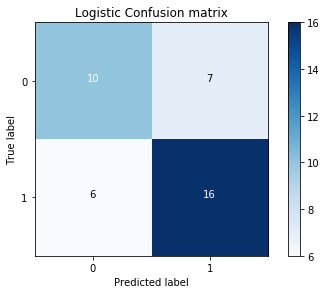

Accuracy  =     0.667
Precision =     0.696
Recall    =     0.727
F1_score  =     0.711


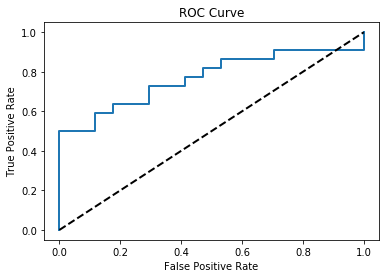

In [59]:
from sklearn.metrics import roc_curve
random_state = 42
# Find best hyperparameters (accuracy)
log_clf = LogisticRegression(random_state = random_state)
param_grid = {
            'penalty' : ['l2','l1'],  
            'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
            }

CV_log_clf = GridSearchCV(estimator = log_clf, param_grid = param_grid , scoring = 'recall', verbose = 1, n_jobs = -1)
CV_log_clf.fit(X_train, y_train)

best_parameters = CV_log_clf.best_params_
print('The best parameters for using this model is', best_parameters)

#Log with best hyperparameters
CV_log_clf = LogisticRegression(C = best_parameters['C'], 
                                penalty = best_parameters['penalty'], 
                                random_state = random_state)

CV_log_clf.fit(X_train, y_train)
y_pred = CV_log_clf.predict(X_test)
y_score = CV_log_clf.decision_function(X_test)

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='Logistic Confusion matrix')
plt.savefig('6')
plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

Logistic regression with RFE

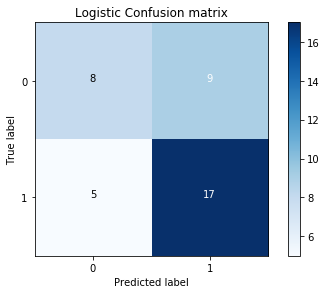

Accuracy  =     0.641
Precision =     0.654
Recall    =     0.773
F1_score  =     0.708


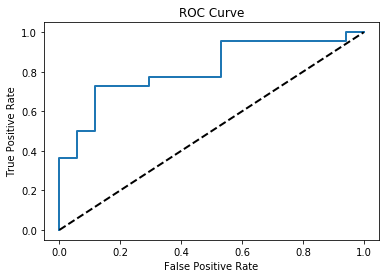

In [60]:
from sklearn.feature_selection import RFE
#Logistic regression with RFE
log_clf = LogisticRegression(C = best_parameters['C'], 
                                 penalty = best_parameters['penalty'], 
                                 random_state = random_state)

selector = RFE(log_clf)
selector = selector.fit(X_train, y_train)

y_pred = selector.predict(X_test)
y_score = selector.predict_proba(X_test)[:,1]


# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='Logistic Confusion matrix')
plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

[False  True  True  True False False False  True False]
[3 1 1 1 5 2 4 1 6]


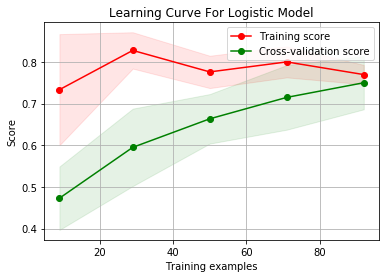

In [61]:
# support and ranking RFE
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split
print(selector.support_)
print(selector.ranking_)
#Learning curve Log with best hyperpara
plot_learning_curve(CV_log_clf, 'Learning Curve For Logistic Model', X, y)
plt.savefig('7')
plt.show()

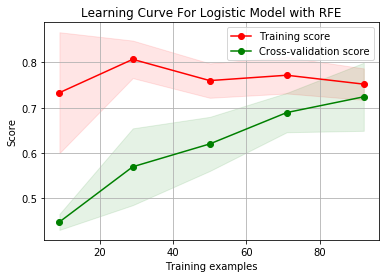

In [62]:
#Learning curve Log with RFE
plot_learning_curve(selector, 'Learning Curve For Logistic Model with RFE', X, y)
plt.show()

In [63]:
# Cross val Log 
cross_log = cross_val_metrics(CV_log_clf)
# Cross val Log with RFE
cross_selector = cross_val_metrics(selector)

[accuracy] : 0.73261 (+/- 0.03340)
[precision] : 0.79458 (+/- 0.08561)
[recall] : 0.71795 (+/- 0.08108)
[accuracy] : 0.72428 (+/- 0.07510)
[precision] : 0.76218 (+/- 0.12227)
[recall] : 0.76538 (+/- 0.04925)


#  Select threshold for a recall = 100% (all malignant tumors detected)¶


Recall w/ threshold = 0.1 : 0.9090909090909091
Recall w/ threshold = 0.2 : 0.8636363636363636
Recall w/ threshold = 0.3 : 0.8181818181818182
Recall w/ threshold = 0.4 : 0.7727272727272727
Recall w/ threshold = 0.5 : 0.7272727272727273
Recall w/ threshold = 0.6 : 0.7272727272727273
Recall w/ threshold = 0.7 : 0.6363636363636364
Recall w/ threshold = 0.8 : 0.6363636363636364
Recall w/ threshold = 0.9 : 0.5


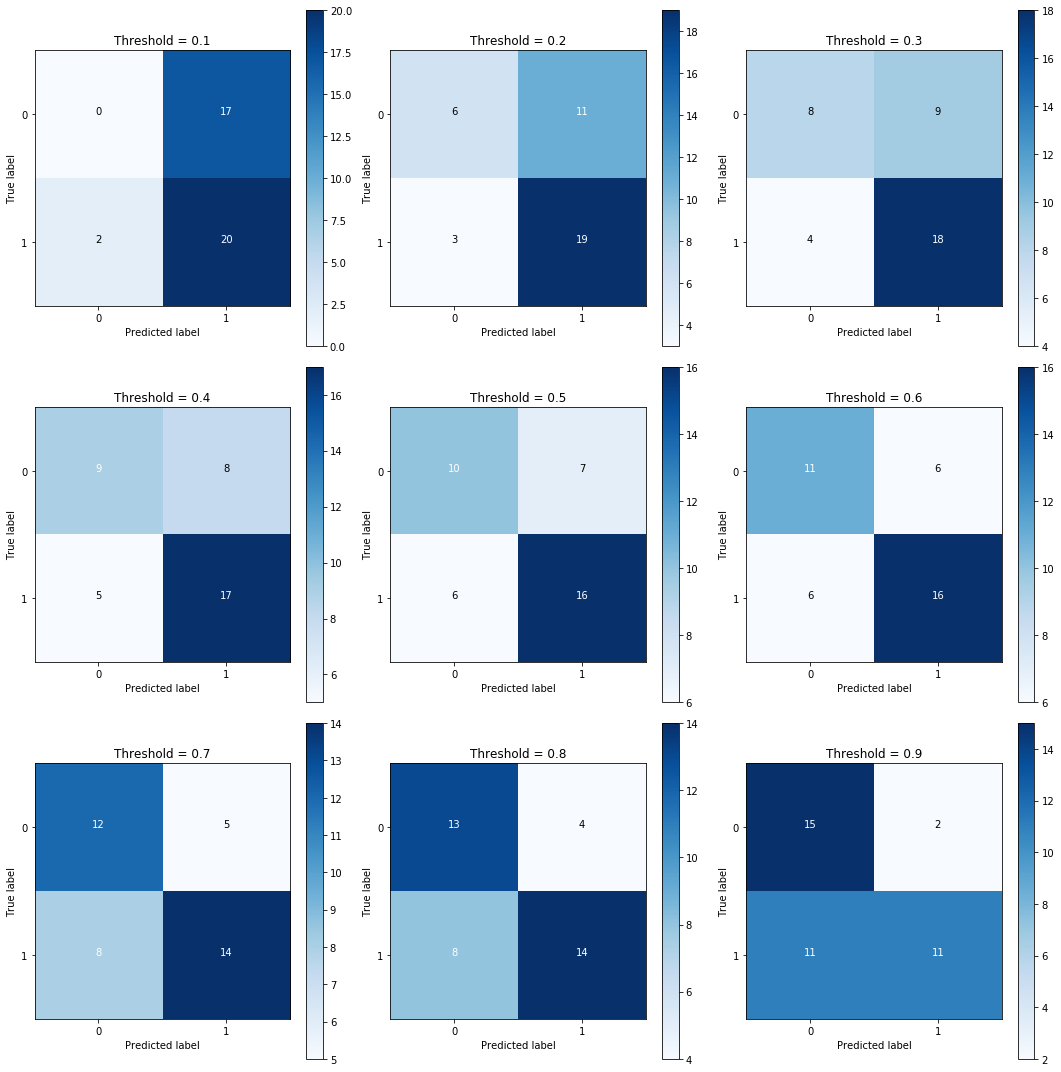

In [64]:
# Threshold
thresholds_adj = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize = (15,15))

j = 1
for i in thresholds_adj:
    y_score = CV_log_clf.predict_proba(X_test)[:,1] > i
    
    
    plt.subplot(3,3,j)
    j += 1
    
    cm = confusion_matrix(y_test, y_score)
    
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]

    print('Recall w/ threshold = %s :'%i, (tp/(tp+fn)))
    
    class_names = [0,1]
    plot_confusion_matrix(cm, 
                          classes=class_names, 
                          title='Threshold = %s'%i) 

In [65]:
#Predicting with recall = 100%
# Recall = 1.
y_score = CV_log_clf.predict_proba(X_test)[:,1] > 0.3
cm = confusion_matrix(y_test, y_score)
class_names = [0,1]
show_metrics()

Accuracy  =     0.667
Precision =     0.667
Recall    =     0.818
F1_score  =     0.735


With 2 models we can increase the precision while keeping a recall = 100%

7. Predictive model 2 : Ensemble Classifier to maximise precision and detect all malignant tumors
7.1. Logistic Regression and GridSearch CV to optimise hyperparameters (recall)

In [66]:
# Find the best parameters (recall)
log2_clf = LogisticRegression(random_state = random_state)
param_grid = {
            'penalty' : ['l2','l1'],  
            'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            }

CV_log2_clf = GridSearchCV(estimator = log2_clf, param_grid = param_grid , scoring = 'accuracy', verbose = 1, n_jobs = -1)
CV_log2_clf.fit(X_train, y_train)

best_parameters = CV_log2_clf.best_params_
print('The best parameters for using this model is', best_parameters)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The best parameters for using this model is {'C': 10, 'penalty': 'l2'}


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.6s finished


In [67]:
# Log w best hyperparameters (recall)
CV_log2_clf = LogisticRegression(C = best_parameters['C'], 
                                 penalty = best_parameters['penalty'], 
                                 random_state = random_state)


CV_log2_clf.fit(X_train, y_train)

y_pred = CV_log2_clf.predict(X_test)
y_score = CV_log2_clf.decision_function(X_test)
# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
cm

array([[10,  7],
       [ 6, 16]])

In [68]:
cross_val_metrics(CV_log2_clf)

[accuracy] : 0.74167 (+/- 0.06589)
[precision] : 0.80359 (+/- 0.12094)
[recall] : 0.73333 (+/- 0.08205)


Voting classifier : log + log2


In [69]:
from sklearn.ensemble import GradientBoostingClassifier
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)
clf_gbc.score(X_test, y_test)
y_pred = clf_gbc.predict(X_test)
y_score = clf_gbc.predict_proba(X_test)[:,1]

# Confusion maxtrix
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
print(cm)
show_metrics()

[[ 9  8]
 [ 2 20]]
Accuracy  =     0.744
Precision =     0.714
Recall    =     0.909
F1_score  =     0.800


In [70]:
from sklearn.ensemble import VotingClassifier
#Voting Classifier
voting_clf = VotingClassifier (
        estimators = [('log1', clf_gnb), ('log_2', clf_rf),('log3', CV_log_clf),('log4',clf_gbc),
                      ('svmrbf',clf_svmrbf),('knn',clf_knn),('clf_svmsigmoid',clf_svmsigmoid)],
                     voting='soft', weights = [1.2,8,2,1,2,1.5,2])#, weights = [1.2,3,2,1,2,1.5,2]
# voting_clf = VotingClassifier (
#         estimators = [('log1', CV_log_clf), ('log_2', CV_log2_clf)],
#                      voting='soft', weights = [1,2])
voting_clf.fit(X_train,y_train)

y_pred = voting_clf.predict(X_test)
y_score = voting_clf.predict_proba(X_test)[:,1]

# Confusion maxtrix
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
print(cm)
show_metrics()
from sklearn.metrics import roc_auc_score
print('auc= ',roc_auc_score(y_test,y_score))

[[ 9  8]
 [ 4 18]]
Accuracy  =     0.692
Precision =     0.692
Recall    =     0.818
F1_score  =     0.750
auc=  0.8181818181818181


In [71]:
# voting_clf = VotingClassifier (
#         estimators = [('log1', clf_gnb), ('log_2', clf_rf),('log3', CV_log_clf),('log4',clf_gbc)],
#                      voting='soft')
# params = {'weights':[[1.2,2.8,2,0.8],[1.1,2.9,2,0.5],[0.5,1,1.5,2,2.5,3],[0.5,1,1.5,2,2.5,3]]}
# grid_Search = GridSearchCV(param_grid = params, estimator=voting_clf,scoring='recall')
# grid_Search.fit(X_train,y_train)
# print(grid_Search.best_Score_)

In [72]:
# Cross val score voting
cross_voting = cross_val_metrics(voting_clf)

[accuracy] : 0.74094 (+/- 0.06861)
[precision] : 0.78286 (+/- 0.05009)
[recall] : 0.76667 (+/- 0.08205)


Recall w/ threshold = 0.1 : 1.0 precision =  0.0
Recall w/ threshold = 0.2 : 1.0 precision =  0.0
Recall w/ threshold = 0.3 : 0.9545454545454546 precision =  0.11764705882352941
Recall w/ threshold = 0.4 : 0.9545454545454546 precision =  0.4117647058823529
Recall w/ threshold = 0.5 : 0.8181818181818182 precision =  0.5294117647058824
Recall w/ threshold = 0.52 : 0.8181818181818182 precision =  0.6470588235294118
Recall w/ threshold = 0.6 : 0.6818181818181818 precision =  0.7647058823529411
Recall w/ threshold = 0.7 : 0.5909090909090909 precision =  0.9411764705882353
Recall w/ threshold = 0.8 : 0.045454545454545456 precision =  1.0


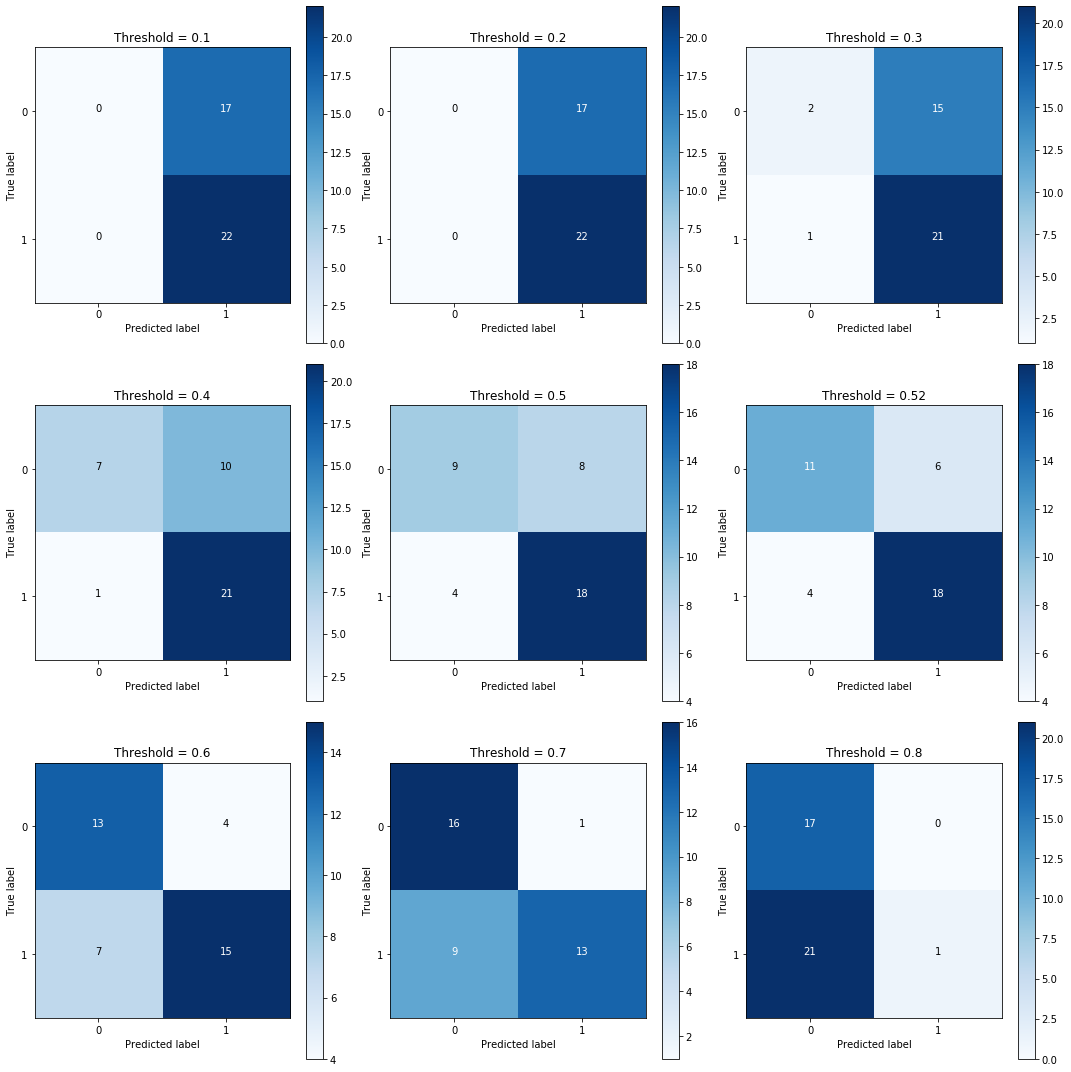

In [73]:
# Threshold
thresholds_adj = [0.1,0.2,0.3,0.4,0.5,0.52,0.6,0.7,0.8]

plt.figure(figsize = (15,15))

j = 1
for i in thresholds_adj:
    y_score = voting_clf.predict_proba(X_test)[:,1] > i
    
    
    plt.subplot(3,3,j)
    j += 1
    
    cm = confusion_matrix(y_test, y_score)
    
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]

    print('Recall w/ threshold = %s :'%i, (tp/(tp+fn)),'precision = ',tn/(tn+fp))
    
    class_names = [0,1]
    plot_confusion_matrix(cm, 
                          classes=class_names, 
                          title='Threshold = %s'%i)

In [74]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [75]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [76]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
# rf_random.fit(X_train, y_train)

In [77]:
# rf_random.best_params_

In [78]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.3385 degrees.
Accuracy = -inf%.


AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [79]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [80]:
# Fit the grid search to the data
# grid_search.fit(X_train, y_train)
grid_search.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [81]:

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [82]:
y_pred = grid_search.predict(X_test)
# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred.round())
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='Logistic Confusion matrix')
plt.savefig('6')
plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

Accuracy  =     0.692
Precision =     0.667
Recall    =     0.909
F1_score  =     0.769


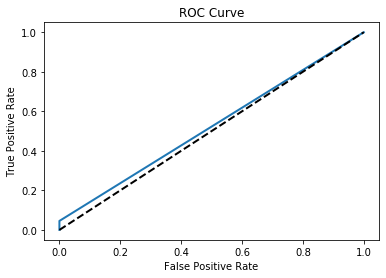

In [83]:
forestVC = RandomForestClassifier(random_state = 1,
                                  n_estimators = 750,
                                  max_depth = 15, 
                                  min_samples_split = 5,  min_samples_leaf = 1) 
modelVC = forestVC.fit(X_train, y_train) 
y_pred = modelVC.predict(X_test)
# y_score = modelVC.decision_function(X_test)
# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred.round())
class_names = [0,1]
# plt.figure()
# plot_confusion_matrix(cm, 
#                       classes=class_names, 
#                       title='Random forest Confusion matrix')
# plt.savefig('6')
# plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

In [84]:
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
model = XGBClassifier()
# define grid
weights = [1, 10, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X, y)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.837407 using {'scale_pos_weight': 1000}
0.799683 (0.105175) with: {'scale_pos_weight': 1}
0.816032 (0.104904) with: {'scale_pos_weight': 10}
0.822725 (0.099857) with: {'scale_pos_weight': 25}
0.827249 (0.090803) with: {'scale_pos_weight': 50}
0.821085 (0.096862) with: {'scale_pos_weight': 75}
0.823280 (0.099230) with: {'scale_pos_weight': 99}
0.822910 (0.101034) with: {'scale_pos_weight': 100}
0.837407 (0.086609) with: {'scale_pos_weight': 1000}


In [85]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
scores = cross_val_score(clf, X_test, y_test, cv=5)
print("Random Forest Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))
print(classification_report( y_test,prediction))

Random Forest Accuracy: 79.49%
Cross validation score: 66.07% (+/- 25.15%)
              precision    recall  f1-score   support

           0       0.91      0.59      0.71        17
           1       0.75      0.95      0.84        22

    accuracy                           0.79        39
   macro avg       0.83      0.77      0.78        39
weighted avg       0.82      0.79      0.79        39



Recall w/ threshold = 0.1 : 1.0 precision =  0.0
Recall w/ threshold = 0.2 : 1.0 precision =  0.17647058823529413
Recall w/ threshold = 0.3 : 1.0 precision =  0.23529411764705882
Recall w/ threshold = 0.4 : 0.9545454545454546 precision =  0.4117647058823529
Recall w/ threshold = 0.5 : 0.9545454545454546 precision =  0.5882352941176471
Recall w/ threshold = 0.6 : 0.7727272727272727 precision =  0.6470588235294118
Recall w/ threshold = 0.7 : 0.5909090909090909 precision =  0.8235294117647058
Recall w/ threshold = 0.8 : 0.36363636363636365 precision =  0.9411764705882353
Recall w/ threshold = 0.9 : 0.13636363636363635 precision =  0.9411764705882353
[accuracy] : 0.72355 (+/- 0.04690)
[precision] : 0.73051 (+/- 0.03456)
[recall] : 0.82949 (+/- 0.07383)
Accuracy  =     0.718
Precision =     0.739
Recall    =     0.773
F1_score  =     0.756


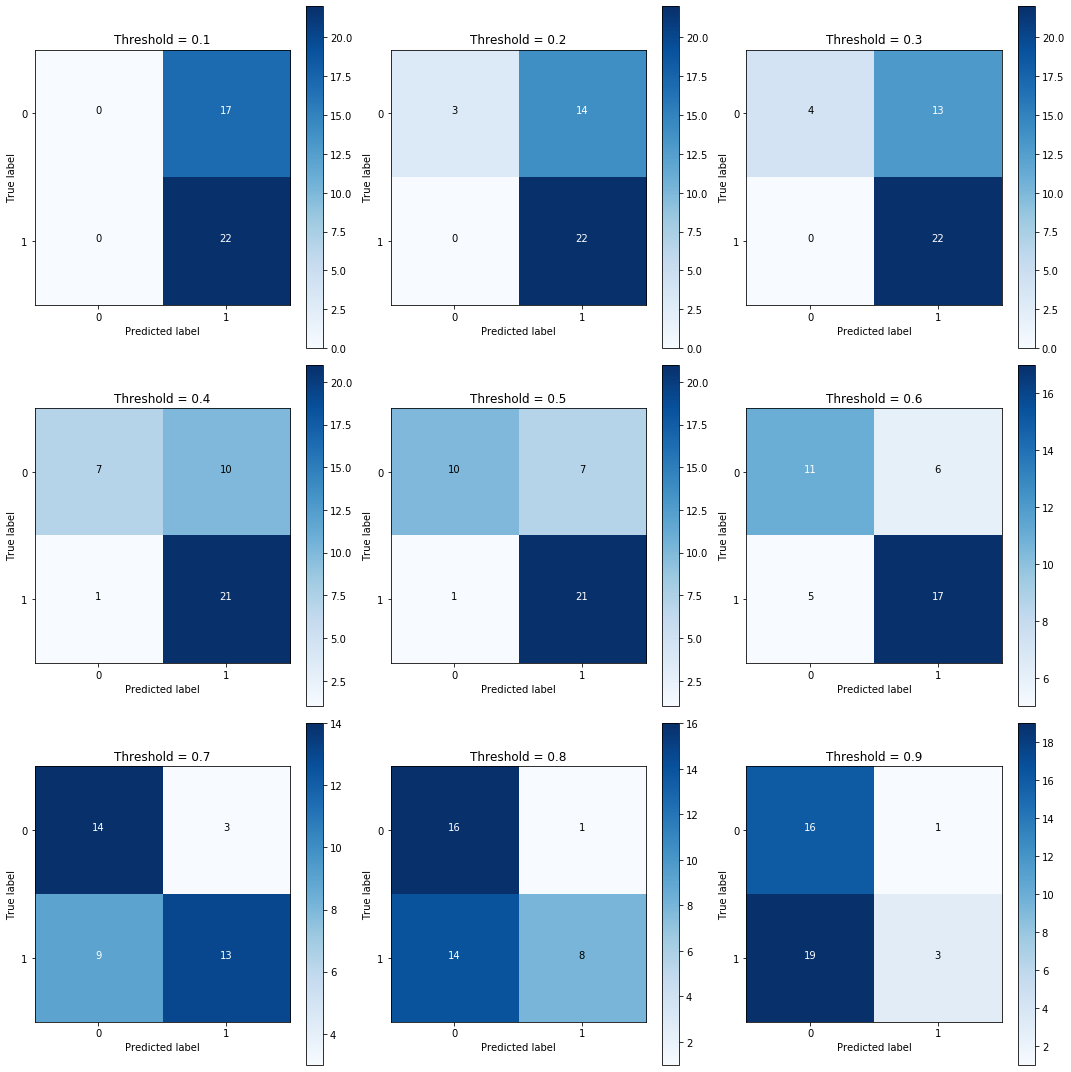

In [86]:
# Threshold
thresholds_adj = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize = (15,15))

j = 1
for i in thresholds_adj:
    y_score = clf.predict_proba(X_test)[:,1] > i
    
    
    plt.subplot(3,3,j)
    j += 1
    
    cm = confusion_matrix(y_test, y_score)
    
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]

    print('Recall w/ threshold = %s :'%i, (tp/(tp+fn)),'precision = ',tn/(tn+fp))
    
    class_names = [0,1]
    plot_confusion_matrix(cm, 
                          classes=class_names, 
                          title='Threshold = %s'%i)
y_score = clf.predict_proba(X_test)[:,1] > 0.6
cross_voting = cross_val_metrics(clf)
cm = confusion_matrix(y_test, y_score)
class_names = [0,1]
show_metrics()